### Raw data

* Number of users: 24 million
* Number of projects: 83 million
* Number of commits: 1 billion

In [74]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [92]:
%%time
df=pd.read_csv('/storage2/mysql-2018-04-01/commits.csv',header=None,usecols=['user','repo'],names=['id','sha','user1','user','repo','date'],na_values='\\N')
df.dropna(inplace=True)
df['count']=1
df['repo']=df['repo'].astype('int32')

CPU times: user 8min 8s, sys: 1min 2s, total: 9min 10s
Wall time: 9min 37s


In [93]:
%%time
ndf=df.groupby(['user','repo']).count()

CPU times: user 4min 48s, sys: 54.4 s, total: 5min 42s
Wall time: 5min 56s


In [94]:
%%time
ndf=ndf.dropna()
#ndf=ndf[(ndf>3)&(ndf<40000)].dropna()
ndf['count']=ndf['count'].astype('int32')

CPU times: user 5.22 s, sys: 2.73 s, total: 7.95 s
Wall time: 7.96 s


In [59]:
# groupby&unstack seems to be faster than pivot_table
#ndf=ndf.unstack()

In [95]:
import sys
print('dataframe:',int(sys.getsizeof(df)/1024/1024),'MB, length: ', len(df))
print('filtered:',int(sys.getsizeof(ndf)/1024/1024),'MB, length: ',len(ndf))

dataframe: 24838 MB, length:  930193545
filtered: 1327 MB, length:  73999902


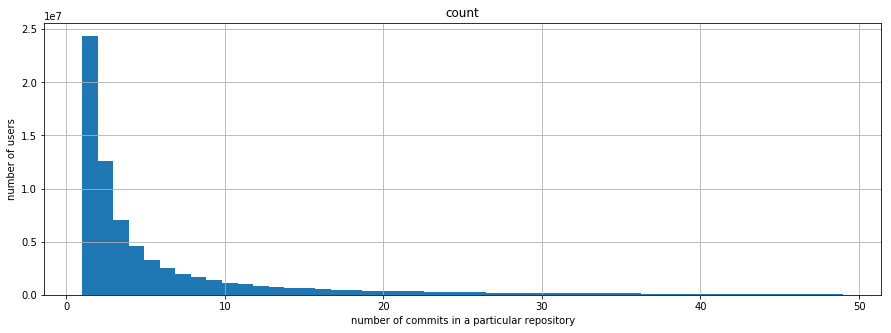

In [96]:
plt.rcParams["figure.figsize"] = [15,5]
ndf[ndf<50].hist(bins=49)
plt.xlabel('number of commits in a particular repository')
plt.ylabel('number of users');